# Assignment - 6

In [41]:
import os
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, models
import torch.optim as optim
from PIL import Image
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

%matplotlib inline

In [73]:
training_dataset = "D:/MTECH/Sem-2/Deep Learning/tiny-imagenet-200/tiny-imagenet-200/train"
training_labels = "D:/MTECH/Sem-2/Deep Learning/tiny-imagenet-200/tiny-imagenet-200/words.txt"

# Q.1 

## (a), (b), (c), (d)

In [74]:
classes = []
class_paths = []

i = 0
while i < 10:
    class_name = random.choice(os.listdir(training_dataset))
    if class_name not in classes:
        classes.append(class_name)
        class_paths.append(os.path.join(training_dataset, class_name))
        i += 1
    else:
        continue

In [77]:
with open(training_labels) as file:
    lines = file.readlines()
    
target_dict = {}
for line in lines:
    words = line.strip().replace('\t', ' ').split(" ")
    if words[0] in classes:
        target_dict[words[0]] = words[1].strip(',')
    else:
        continue

In [78]:
target_dict

{'n01644900': 'tailed',
 'n01774384': 'black',
 'n02730930': 'apron',
 'n02892201': 'brass',
 'n02999410': 'chain',
 'n04371430': 'swimming',
 'n04487081': 'trolleybus',
 'n04507155': 'umbrella',
 'n07695742': 'pretzel',
 'n07871810': 'meat'}

In [79]:
target_encoded = {}
for i, key in enumerate(target_dict):
    target_encoded[target_dict[key]] = i 

target_encoded

{'tailed': 0,
 'black': 1,
 'apron': 2,
 'brass': 3,
 'chain': 4,
 'swimming': 5,
 'trolleybus': 6,
 'umbrella': 7,
 'pretzel': 8,
 'meat': 9}

In [81]:
data = []
targets = []

for path in class_paths:
    image_paths = os.path.join(path,"images/")
    for image_name in os.listdir(image_paths):
        targets.append(target_encoded[target_dict[image_name[:9]]])
        image_path = os.path.join(image_paths, image_name)
        image = Image.open(image_path)
        if len(np.array(image).shape) == 2:
            image = cv2.cvtColor(np.float32(image),cv2.COLOR_GRAY2RGB)
            
        image = np.array(image)
        data.append(image.swapaxes(0,2))

In [82]:
X_temp, X_test, y_temp, y_test = train_test_split(data, targets, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125)

In [83]:
print("X_train shape: {}".format(len(X_train)))
print("X_test shape: {}".format(len(X_test)))
print("y_train shape: {}".format(len(y_train)))
print("y_test shape: {}".format(len(y_test)))
print("X_val shape: {}".format(len(X_val)))
print("y_val shape: {}".format(len(y_val)))

X_train shape: 3500
X_test shape: 1000
y_train shape: 3500
y_test shape: 1000
X_val shape: 500
y_val shape: 500


In [84]:
validation_set = list(zip(X_val, y_val))
test_set = list(zip(X_test, y_test))
train_set = list(zip(X_train, y_train))

## AlexNet

In [86]:
class alexnet(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.results = {}
        self.fhooks = []
        self.fhooks.append(self.model.features[0].register_forward_hook(self.forward_hook('conv1')))
        self.fhooks.append(self.model.features[10].register_forward_hook(self.forward_hook('conv10')))
        self.fhooks.append(self.model.avgpool.register_forward_hook(self.forward_hook('bl')))
        
    def forward_hook(self, layer_name):
        def hook(module, input, output):
            self.results[layer_name] = output
        return hook

    def forward(self, x):
        output = self.model(x)
        return output, self.results

In [91]:
def train_valid_alexnet(train_set, test_set, validation_set, epochs):
    
    trainDataLoader = DataLoader(train_set, shuffle=True, batch_size=100)
    testDataLoader = DataLoader(test_set, shuffle=False, batch_size=10)
    validationDataLoader = DataLoader(validation_set, shuffle=False, batch_size=10)    
    train_step_size = len(trainDataLoader)
    test_step_size = len(testDataLoader)
    validation_step_size = len(validationDataLoader)
    loss_func = nn.CrossEntropyLoss()
    model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=False)
    alexnet_model = alexnet(model)
    opt = optim.Adam(alexnet_model.parameters(), lr = 0.001)
    last_epoch_loss = torch.tensor(1000000)
    trigger = 0

    history = {'train loss': [],
               'validation loss': [],
               'epochs': 0,
               'bl_start':[],
               'bl_end':[],
               'labels': []}

    for epoch in range(epochs):
        history['epochs'] = epoch + 1
        history['bl_end'] = []
        print("\n * * * * * * * * * * * * * * * * Epoch -", epoch+1 ,"* * * * * * * * * * * * * * * * ")
        alexnet_model.train()
        convert_tensor = transforms.ToTensor()
        
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        for (x,y) in trainDataLoader:
            opt.zero_grad()
            pred, maps = alexnet_model(x.float())
            if epoch == 0:
                history['bl_start'].append(maps['bl'])
                history['labels'].append(y)
            else:
                history['bl_end'].append(maps['bl'])
                history['labels'].append(y)
                
            loss = loss_func(pred, y)
            loss.backward()
            opt.step()
            
            train_loss += loss 
            train_acc += (pred.argmax(1) == y).type(torch.float).sum().item()
        
        plt.subplot(1,2,1)
        plt.imshow(maps['conv1'][99][5].detach().numpy())
        plt.title("Output of 1st Convolution Layer")
        plt.subplot(1,2,2)
        plt.imshow(maps['conv10'][99][5].detach().numpy())
        plt.title("Output of Last Convolution Layer")
        plt.subplots_adjust(left=0.5, bottom=0.5, right=2, top=2, wspace=0.5, hspace=0.1)
        plt.show()

        final_train_loss = train_loss/train_step_size
        final_train_acc = train_acc/(train_step_size * 100)
        history['train loss'].append(final_train_loss.detach().numpy())
        
        with torch.no_grad():
            alexnet_model.eval()
            
            for (x,y) in validationDataLoader:
                pred, _ = alexnet_model(x.float())
                val_loss += loss_func(pred,y)
                val_acc += (pred.argmax(1) == y).type(torch.float).sum().item()
            
            final_val_loss = val_loss/validation_step_size
            final_val_acc = val_acc/(validation_step_size * 10)
            history['validation loss'].append(final_val_loss.detach().numpy())
            
            if final_val_loss.detach().numpy() < last_epoch_loss.detach().numpy():
                print("Last epoch loss: ", last_epoch_loss.detach().numpy())
                last_epoch_loss = final_val_loss
            elif (final_val_loss.detach().numpy() - last_epoch_loss.detach().numpy()) > 0.2:
                print("Last epoch loss: ", last_epoch_loss.detach().numpy())
                last_epoch_loss = final_val_loss
                trigger += 1
                print("Trigger: ",trigger)
                if trigger == 2:
                    print("Train loss: ",final_train_loss.detach().numpy(),"\tTrain accuracy: ", final_train_acc)
                    print("Validation loss: ", final_val_loss.detach().numpy(),"\tValidation accuracy: ", final_val_acc)      
                    with torch.no_grad():
                        alexnet_model.eval()
                        test_loss = 0
                        test_acc = 0

                        for (x,y) in testDataLoader:
                            pred, _ = alexnet_model(x.float())
                            test_loss += loss_func(pred,y)
                            test_acc += (pred.argmax(1) == y).type(torch.float).sum().item()
            
                        final_test_loss = test_loss/test_step_size
                        final_test_acc = test_acc/(test_step_size * 10)
                        
                        print(f' - - - - - - - - - - Test Loss: {final_test_loss.detach().numpy():.3f} | Test Accuracy: {final_test_acc*100:.2f}% - - - - - - - - - -')
                        return history
            else:
                last_epoch_loss = final_val_loss

            print(f' - - - - - - - - - - Train Loss: {final_train_loss.detach().numpy():.3f} | Train Accuracy: {final_train_acc*100:.2f}% - - - - - - - - - -')
            print(f' - - - - - - - - - - Validation Loss: {final_val_loss.detach().numpy():.3f}  | Validation Accuracy: {final_val_acc*100:.2f}% - - - - - - - - - -')
  
    with torch.no_grad():
        alexnet_model.eval()
        test_loss = 0
        test_acc = 0

        for (x,y) in testDataLoader:
            pred, _ = alexnet_model(x.float())
            test_loss += loss_func(pred,y)
            test_acc += (pred.argmax(1) == y).type(torch.float).sum().item()    
        final_test_loss = test_loss/test_step_size
        final_test_acc = test_acc/(test_step_size * 10)
        
        print(f' - - - - - - - - - - Test Loss: {final_test_loss.detach().numpy():.3f} | Test Accuracy: {final_test_acc*100:.2f}% - - - - - - - - - -')
    return history

Using cache found in C:\Users\amanl/.cache\torch\hub\pytorch_vision_v0.10.0



 * * * * * * * * * * * * * * * * Epoch - 1 * * * * * * * * * * * * * * * * 


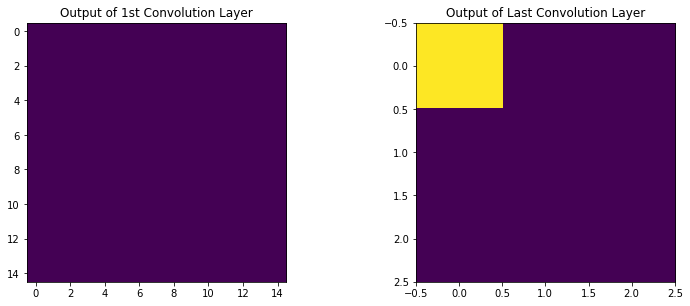

Last epoch loss:  1000000
 - - - - - - - - - - Train Loss: 7.510 | Train Accuracy: 9.26% - - - - - - - - - -
 - - - - - - - - - - Validation Loss: 2.728  | Validation Accuracy: 9.80% - - - - - - - - - -

 * * * * * * * * * * * * * * * * Epoch - 2 * * * * * * * * * * * * * * * * 


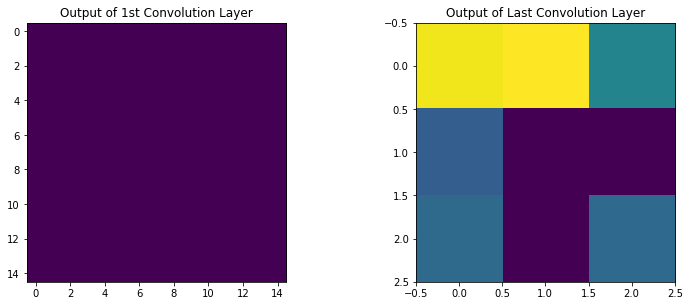

Last epoch loss:  2.7284763
 - - - - - - - - - - Train Loss: 2.454 | Train Accuracy: 10.11% - - - - - - - - - -
 - - - - - - - - - - Validation Loss: 2.325  | Validation Accuracy: 10.60% - - - - - - - - - -

 * * * * * * * * * * * * * * * * Epoch - 3 * * * * * * * * * * * * * * * * 


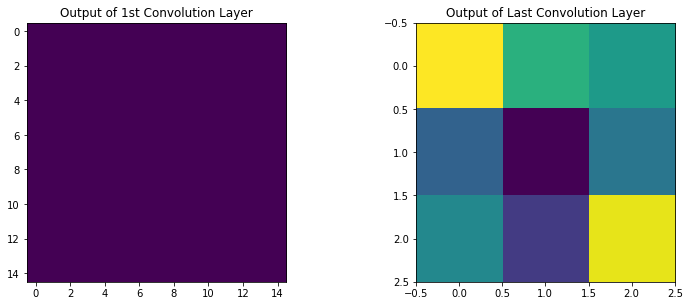

Last epoch loss:  2.3249152
 - - - - - - - - - - Train Loss: 2.289 | Train Accuracy: 12.54% - - - - - - - - - -
 - - - - - - - - - - Validation Loss: 2.222  | Validation Accuracy: 16.40% - - - - - - - - - -

 * * * * * * * * * * * * * * * * Epoch - 4 * * * * * * * * * * * * * * * * 


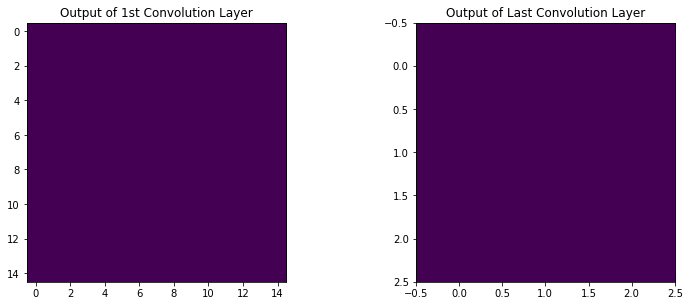

Last epoch loss:  2.2215002
 - - - - - - - - - - Train Loss: 2.191 | Train Accuracy: 16.23% - - - - - - - - - -
 - - - - - - - - - - Validation Loss: 2.124  | Validation Accuracy: 24.40% - - - - - - - - - -

 * * * * * * * * * * * * * * * * Epoch - 5 * * * * * * * * * * * * * * * * 


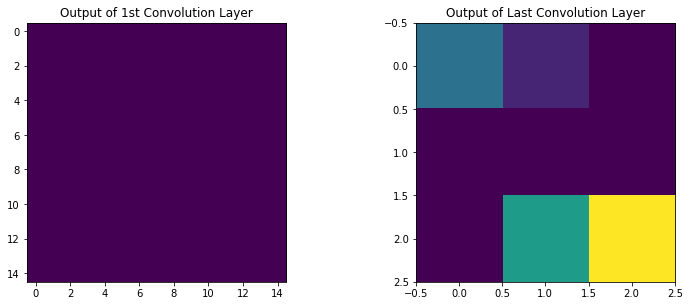

Last epoch loss:  2.1236455
 - - - - - - - - - - Train Loss: 2.127 | Train Accuracy: 17.89% - - - - - - - - - -
 - - - - - - - - - - Validation Loss: 2.050  | Validation Accuracy: 22.20% - - - - - - - - - -

 * * * * * * * * * * * * * * * * Epoch - 6 * * * * * * * * * * * * * * * * 


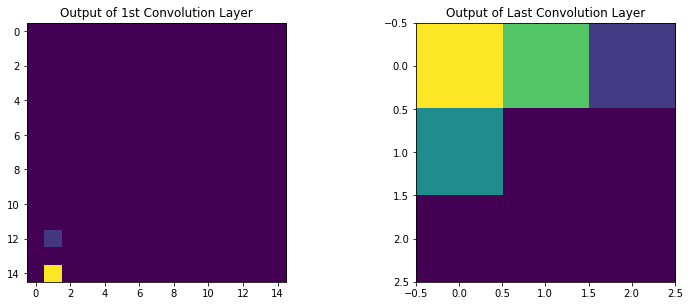

 - - - - - - - - - - Train Loss: 2.049 | Train Accuracy: 23.03% - - - - - - - - - -
 - - - - - - - - - - Validation Loss: 2.143  | Validation Accuracy: 19.20% - - - - - - - - - -

 * * * * * * * * * * * * * * * * Epoch - 7 * * * * * * * * * * * * * * * * 


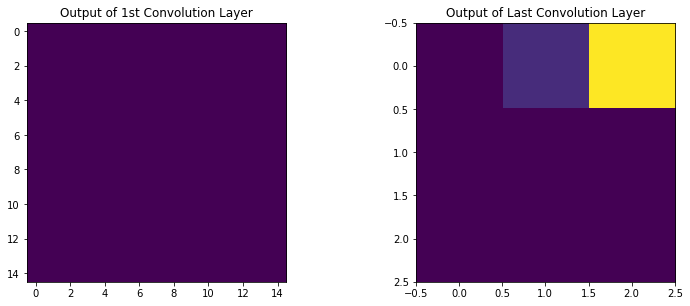

Last epoch loss:  2.1425087
 - - - - - - - - - - Train Loss: 1.971 | Train Accuracy: 28.17% - - - - - - - - - -
 - - - - - - - - - - Validation Loss: 1.955  | Validation Accuracy: 28.60% - - - - - - - - - -

 * * * * * * * * * * * * * * * * Epoch - 8 * * * * * * * * * * * * * * * * 


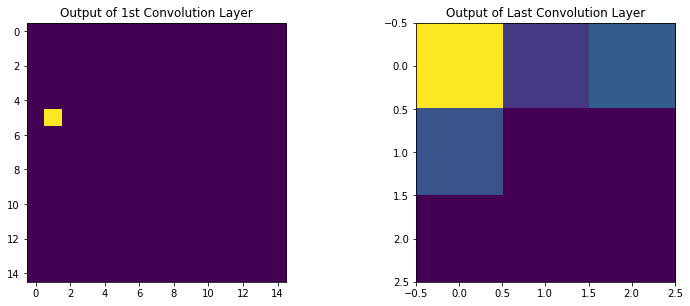

Last epoch loss:  1.9546959
 - - - - - - - - - - Train Loss: 1.865 | Train Accuracy: 31.51% - - - - - - - - - -
 - - - - - - - - - - Validation Loss: 1.892  | Validation Accuracy: 33.20% - - - - - - - - - -

 * * * * * * * * * * * * * * * * Epoch - 9 * * * * * * * * * * * * * * * * 


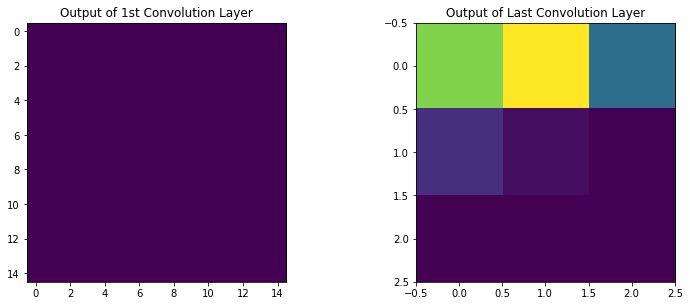

 - - - - - - - - - - Train Loss: 1.793 | Train Accuracy: 34.63% - - - - - - - - - -
 - - - - - - - - - - Validation Loss: 1.899  | Validation Accuracy: 33.00% - - - - - - - - - -

 * * * * * * * * * * * * * * * * Epoch - 10 * * * * * * * * * * * * * * * * 


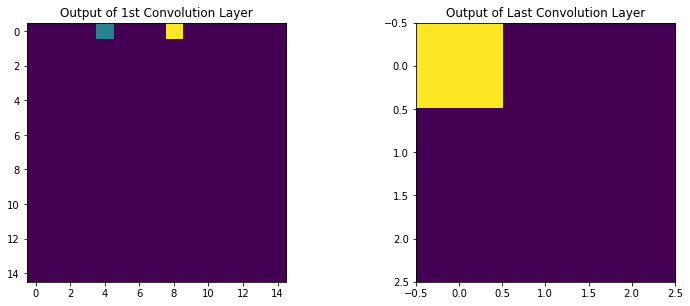

 - - - - - - - - - - Train Loss: 1.709 | Train Accuracy: 38.43% - - - - - - - - - -
 - - - - - - - - - - Validation Loss: 1.915  | Validation Accuracy: 30.80% - - - - - - - - - -

 * * * * * * * * * * * * * * * * Epoch - 11 * * * * * * * * * * * * * * * * 


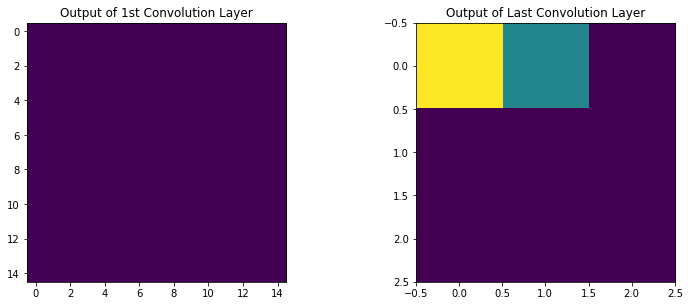

Last epoch loss:  1.9149513
 - - - - - - - - - - Train Loss: 1.623 | Train Accuracy: 40.54% - - - - - - - - - -
 - - - - - - - - - - Validation Loss: 1.866  | Validation Accuracy: 34.00% - - - - - - - - - -

 * * * * * * * * * * * * * * * * Epoch - 12 * * * * * * * * * * * * * * * * 


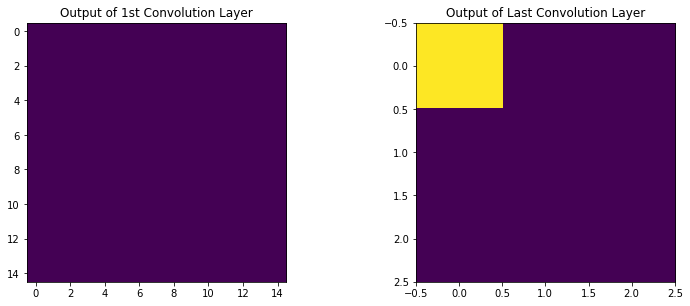

 - - - - - - - - - - Train Loss: 1.529 | Train Accuracy: 45.03% - - - - - - - - - -
 - - - - - - - - - - Validation Loss: 2.018  | Validation Accuracy: 37.00% - - - - - - - - - -

 * * * * * * * * * * * * * * * * Epoch - 13 * * * * * * * * * * * * * * * * 


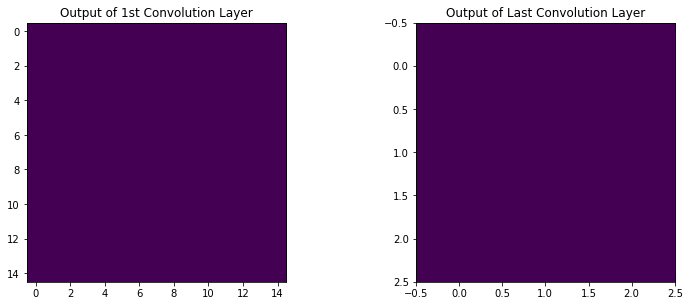

Last epoch loss:  2.0178938
 - - - - - - - - - - Train Loss: 1.499 | Train Accuracy: 46.14% - - - - - - - - - -
 - - - - - - - - - - Validation Loss: 2.013  | Validation Accuracy: 31.40% - - - - - - - - - -

 * * * * * * * * * * * * * * * * Epoch - 14 * * * * * * * * * * * * * * * * 


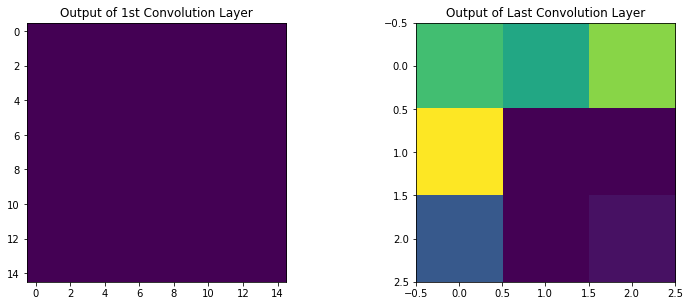

Last epoch loss:  2.0133584
 - - - - - - - - - - Train Loss: 1.535 | Train Accuracy: 45.14% - - - - - - - - - -
 - - - - - - - - - - Validation Loss: 1.956  | Validation Accuracy: 39.20% - - - - - - - - - -

 * * * * * * * * * * * * * * * * Epoch - 15 * * * * * * * * * * * * * * * * 


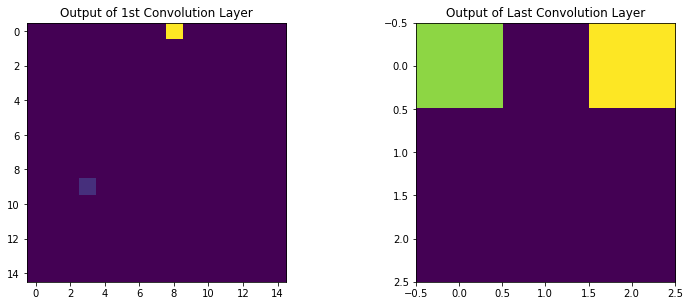

Last epoch loss:  1.9559518
 - - - - - - - - - - Train Loss: 1.434 | Train Accuracy: 48.49% - - - - - - - - - -
 - - - - - - - - - - Validation Loss: 1.948  | Validation Accuracy: 36.60% - - - - - - - - - -

 * * * * * * * * * * * * * * * * Epoch - 16 * * * * * * * * * * * * * * * * 


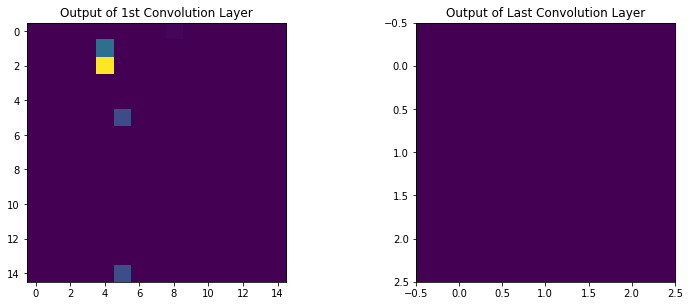

 - - - - - - - - - - Train Loss: 1.311 | Train Accuracy: 53.23% - - - - - - - - - -
 - - - - - - - - - - Validation Loss: 2.000  | Validation Accuracy: 37.40% - - - - - - - - - -

 * * * * * * * * * * * * * * * * Epoch - 17 * * * * * * * * * * * * * * * * 


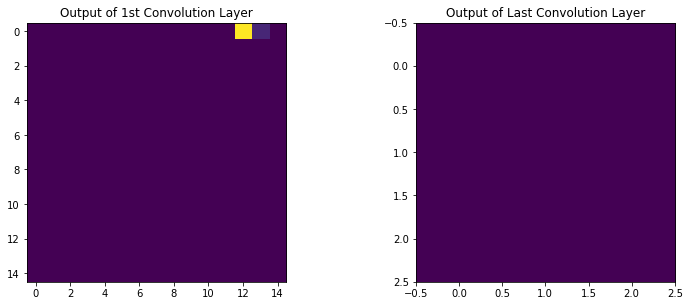

Last epoch loss:  2.0002325
 - - - - - - - - - - Train Loss: 1.224 | Train Accuracy: 56.51% - - - - - - - - - -
 - - - - - - - - - - Validation Loss: 1.873  | Validation Accuracy: 42.20% - - - - - - - - - -

 * * * * * * * * * * * * * * * * Epoch - 18 * * * * * * * * * * * * * * * * 


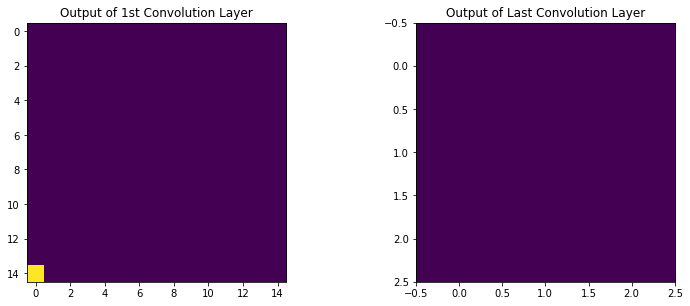

Last epoch loss:  1.8732653
Trigger:  1
 - - - - - - - - - - Train Loss: 1.016 | Train Accuracy: 63.34% - - - - - - - - - -
 - - - - - - - - - - Validation Loss: 2.209  | Validation Accuracy: 37.40% - - - - - - - - - -

 * * * * * * * * * * * * * * * * Epoch - 19 * * * * * * * * * * * * * * * * 


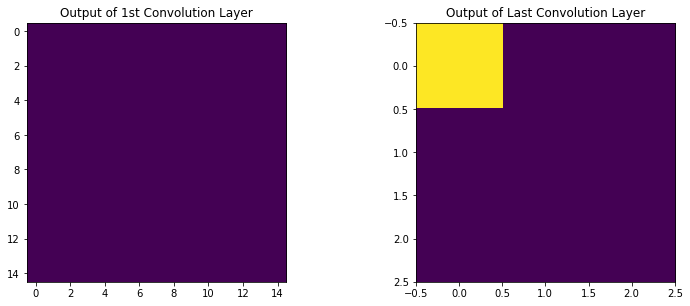

 - - - - - - - - - - Train Loss: 0.962 | Train Accuracy: 65.91% - - - - - - - - - -
 - - - - - - - - - - Validation Loss: 2.214  | Validation Accuracy: 37.40% - - - - - - - - - -

 * * * * * * * * * * * * * * * * Epoch - 20 * * * * * * * * * * * * * * * * 


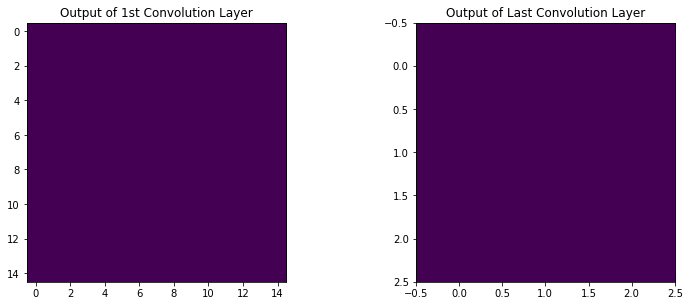

 - - - - - - - - - - Train Loss: 1.046 | Train Accuracy: 62.97% - - - - - - - - - -
 - - - - - - - - - - Validation Loss: 2.366  | Validation Accuracy: 28.80% - - - - - - - - - -
 - - - - - - - - - - Test Loss: 2.255 | Test Accuracy: 34.50% - - - - - - - - - -


In [92]:
result1 = train_valid_alexnet(train_set,test_set,validation_set,20)

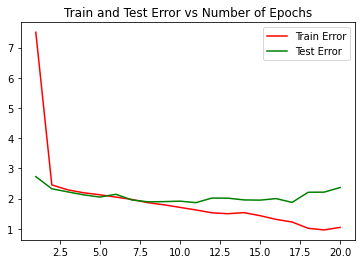

In [94]:
plt.plot(range(1,result1['epochs']+1), [x for x in result1["train loss"]], color="red")
plt.plot(range(1,result1['epochs']+1),[x for x in result1["validation loss"]], color="green")
plt.title("Train and Test Error vs Number of Epochs")
plt.legend(["Train Error", "Test Error"], loc ="best")
plt.show()

In [97]:
colors = ['aqua', 'blue', 'gray', 'gold', 'green', 'fuchsia', 'maroon', 'purple', 'red', 'orange']

<ipython-input-99-1351cb74d0a7>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,1)
<ipython-input-99-1351cb74d0a7>:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)


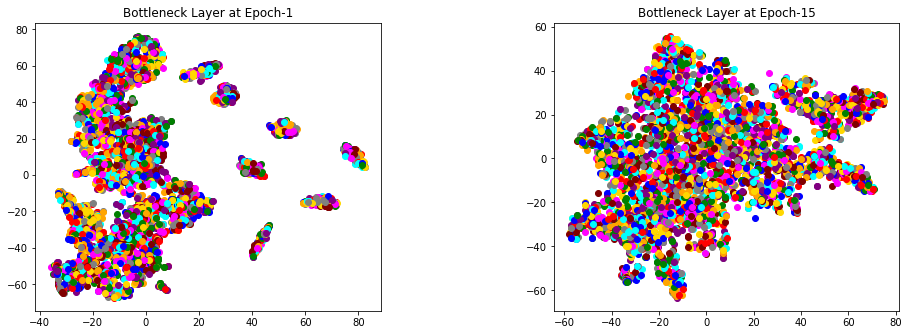

In [99]:
tsne = TSNE()

list_1 = [torch.flatten(vector).detach().numpy() for batch in result1['bl_start'] for vector in batch]
target_1 = [int(label.detach()) for batch in result1['labels'][:35] for label in batch ]

list_2 = [torch.flatten(vector).detach().numpy() for batch in result1['bl_end'] for vector in batch]
target_2 = [int(label.detach()) for batch in result1['labels'][35:] for label in batch ]

bottleneck_embedded1 = tsne.fit_transform(list_1)
bottleneck_embedded2 = tsne.fit_transform(list_2)

for i in range(len(list_1)):
    plt.subplot(1,2,1)
    plt.plot(bottleneck_embedded1[i][0], bottleneck_embedded1[i][1], 'o', color=colors[target_1[i]])
    
plt.title("Bottleneck Layer at Epoch-1")        

for i in range(len(list_2)):
    plt.subplot(1,2,2)
    plt.plot(bottleneck_embedded2[i][0], bottleneck_embedded2[i][1], 'o', color=colors[target_2[i]])
    
plt.title("Bottleneck Layer at Epoch-15")
plt.subplots_adjust(left=1, bottom=2, right=3, top=3, wspace=0.5, hspace=0.1)
plt.show()

## ResNet50

In [100]:
class resnet50(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.results = {}
        self.fhooks = []

        self.fhooks.append(self.model.conv1.register_forward_hook(self.forward_hook('conv1')))
        self.fhooks.append(self.model.layer3[0].conv3.register_forward_hook(self.forward_hook('conv10')))
        self.fhooks.append(self.model.avgpool.register_forward_hook(self.forward_hook('bl')))
        
    def forward_hook(self, layer_name):
        def hook(module, input, output):
            self.results[layer_name] = output
        return hook

    def forward(self, x):
        output = self.model(x)
        return output, self.results


In [103]:
def train_valid_resnet50(train_set, test_set, validation_set, epochs):
  
    trainDataLoader = DataLoader(train_set, shuffle=True, batch_size=100)
    testDataLoader = DataLoader(test_set, shuffle=False, batch_size=10)
    validationDataLoader = DataLoader(validation_set, shuffle=False, batch_size=10)
    
    train_step_size = len(trainDataLoader)
    test_step_size = len(testDataLoader)
    validation_step_size = len(validationDataLoader)
    
    loss_func = nn.CrossEntropyLoss()
    model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=False)
    resnet_model = resnet50(model)
    opt = optim.Adam(resnet_model.parameters(), lr = 0.001)

    last_epoch_loss = torch.tensor(1000000)
    trigger = 0

    history = {'train loss': [],
               'validation loss': [],
               'epochs': 0,
               'bl_start':[],
               'bl_end':[],
               'labels': []}

    for epoch in range(epochs):
        history['epochs'] = epoch + 1
        history['bl_end'] = []
        print("\n * * * * * * * * * * * * * * * * Epoch -", epoch+1 ,"* * * * * * * * * * * * * * * * ")
        resnet_model.train()
        convert_tensor = transforms.ToTensor()
        
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        for (x,y) in trainDataLoader:
            opt.zero_grad()
            pred, maps = resnet_model(x.float())
            if epoch == 0:
                history['bl_start'].append(maps['bl'])
                history['labels'].append(y)
            else:
                history['bl_end'].append(maps['bl'])
                history['labels'].append(y)
                
            loss = loss_func(pred, y)
            loss.backward()
            opt.step()
            train_loss += loss 
            train_acc += (pred.argmax(1) == y).type(torch.float).sum().item()
        
        plt.subplot(1,2,1)
        plt.imshow(maps['conv1'][99][5].detach().numpy())
        plt.title("Output of 1st Convolution Layerr")
        plt.subplot(1,2,2)
        plt.imshow(maps['conv10'][99][5].detach().numpy())
        plt.title("Output of Last Convolution Layer")
        plt.subplots_adjust(left=0.5,bottom=0.5, right=2, top=2, wspace=0.5, hspace=0.1)
        plt.show()

        final_train_loss = train_loss/train_step_size
        final_train_acc = train_acc/(train_step_size * 100)
        history['train loss'].append(final_train_loss.detach().numpy())
        
        with torch.no_grad():
            resnet_model.eval()
            for (x,y) in validationDataLoader:
                pred, _ = resnet_model(x.float())
                val_loss += loss_func(pred,y)
                val_acc += (pred.argmax(1) == y).type(torch.float).sum().item()
            
            final_val_loss = val_loss/validation_step_size
            final_val_acc = val_acc/(validation_step_size * 10)
            history['validation loss'].append(final_val_loss.detach().numpy())
            
            if final_val_loss.detach().numpy() < last_epoch_loss.detach().numpy():
                print("Last epoch loss: ", last_epoch_loss.detach().numpy())
                last_epoch_loss = final_val_loss
            elif (final_val_loss.detach().numpy() - last_epoch_loss.detach().numpy()) > 0.2:
                print("Last epoch loss: ", last_epoch_loss.detach().numpy())
                last_epoch_loss = final_val_loss
                trigger += 1
                print("Trigger: ",trigger)
                if trigger == 2:
                    print("Train loss: ",final_train_loss.detach().numpy(),"\tTrain accuracy: ", final_train_acc)
                    print("Validation loss: ", final_val_loss.detach().numpy(),"\tValidation accuracy: ", final_val_acc)
                    with torch.no_grad():
                        resnet_model.eval()
                        test_loss = 0
                        test_acc = 0

                    for (x,y) in testDataLoader:
                        pred, _ = resnet_model(x.float())
                        test_loss += loss_func(pred,y)
                        test_acc += (pred.argmax(1) == y).type(torch.float).sum().item()
                    final_test_loss = test_loss/test_step_size
                    final_test_acc = test_acc/(test_step_size * 10)
                    print(f' - - - - - - - - - - Test Loss: {final_test_loss.detach().numpy():.3f} | Test Accuracy: {final_test_acc*100:.2f}% - - - - - - - - - -')

                    return history
            else:
                last_epoch_loss = final_val_loss

            print(f' - - - - - - - - - - Train Loss: {final_train_loss.detach().numpy():.3f} | Train Accuracy: {final_train_acc*100:.2f}% - - - - - - - - - -')
            print(f' - - - - - - - - - - Validation Loss: {final_val_loss.detach().numpy():.3f}  | Validation Accuracy: {final_val_acc*100:.2f}% - - - - - - - - - -')

  
    with torch.no_grad():
        resnet_model.eval()
        test_loss = 0
        test_acc = 0

        for (x,y) in testDataLoader:
            pred, _ = resnet_model(x.float())
            test_loss += loss_func(pred,y)
            test_acc += (pred.argmax(1) == y).type(torch.float).sum().item()
            
        final_test_loss = test_loss/test_step_size
        final_test_acc = test_acc/(test_step_size * 10)
        
        print(f' - - - - - - - - - - Test Loss: {final_test_loss.detach().numpy():.3f} | Test Accuracy: {final_test_acc*100:.2f}% - - - - - - - - - -')

    return history

Using cache found in C:\Users\amanl/.cache\torch\hub\pytorch_vision_v0.10.0



 * * * * * * * * * * * * * * * * Epoch - 1 * * * * * * * * * * * * * * * * 


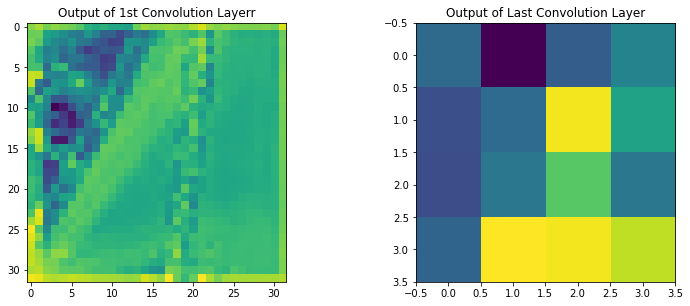

Last epoch loss:  1000000
 - - - - - - - - - - Train Loss: 2.437 | Train Accuracy: 23.83% - - - - - - - - - -
 - - - - - - - - - - Validation Loss: 2.582  | Validation Accuracy: 26.40% - - - - - - - - - -

 * * * * * * * * * * * * * * * * Epoch - 2 * * * * * * * * * * * * * * * * 


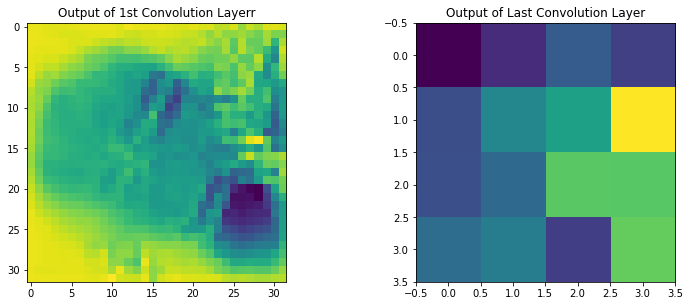

Last epoch loss:  2.582418
 - - - - - - - - - - Train Loss: 1.734 | Train Accuracy: 40.09% - - - - - - - - - -
 - - - - - - - - - - Validation Loss: 1.973  | Validation Accuracy: 33.80% - - - - - - - - - -

 * * * * * * * * * * * * * * * * Epoch - 3 * * * * * * * * * * * * * * * * 


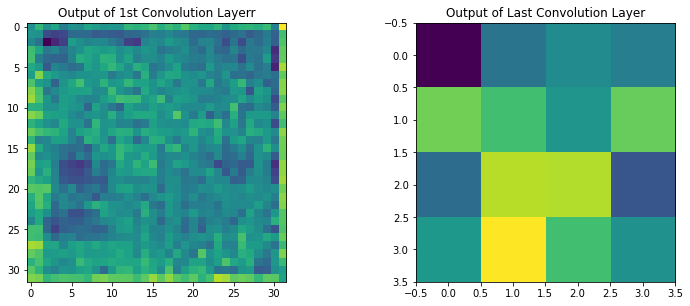

Last epoch loss:  1.9725324
 - - - - - - - - - - Train Loss: 1.486 | Train Accuracy: 49.37% - - - - - - - - - -
 - - - - - - - - - - Validation Loss: 1.751  | Validation Accuracy: 40.00% - - - - - - - - - -

 * * * * * * * * * * * * * * * * Epoch - 4 * * * * * * * * * * * * * * * * 


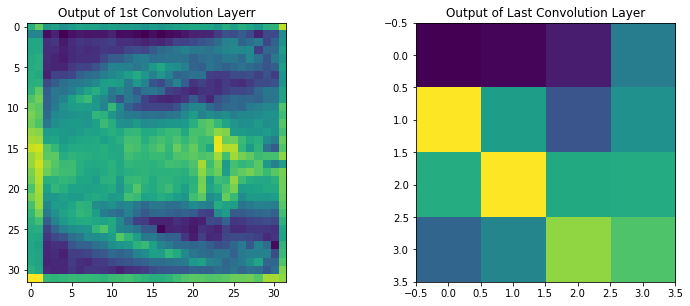

Last epoch loss:  1.7511388
Trigger:  1
 - - - - - - - - - - Train Loss: 1.258 | Train Accuracy: 56.34% - - - - - - - - - -
 - - - - - - - - - - Validation Loss: 1.979  | Validation Accuracy: 38.40% - - - - - - - - - -

 * * * * * * * * * * * * * * * * Epoch - 5 * * * * * * * * * * * * * * * * 


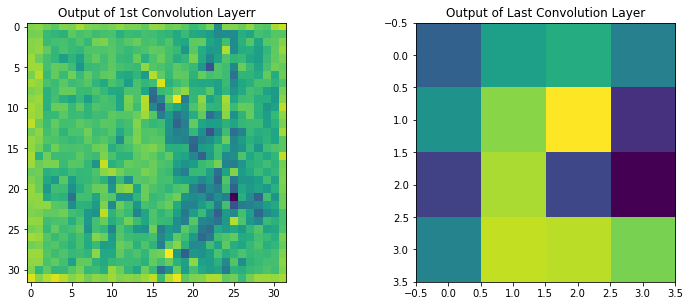

Last epoch loss:  1.9792818
Trigger:  2
Train loss:  1.1012759 	Train accuracy:  0.6185714285714285
Validation loss:  3.4383566 	Validation accuracy:  0.306
 - - - - - - - - - - Test Loss: 3.427 | Test Accuracy: 32.10% - - - - - - - - - -


In [104]:
result2 = train_valid_resnet50(train_set,test_set,validation_set,20)

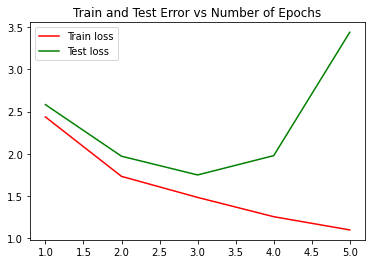

In [107]:
plt.plot(range(1,result2['epochs']+1), [x for x in result2["train loss"]], color="red")
plt.plot(range(1,result2['epochs']+1),[x for x in result2["val loss"]], color="green")
plt.title("Train and Test Error vs Number of Epochs")
plt.legend(["Train loss", "Test loss"], loc ="best")
plt.show()

<ipython-input-108-ef0851bc7f86>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,1)
<ipython-input-108-ef0851bc7f86>:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)


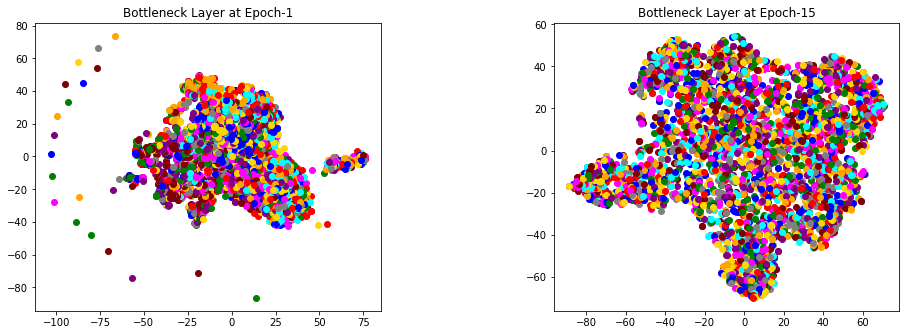

In [108]:
tsne = TSNE()

list_1 = [torch.flatten(vector).detach().numpy() for batch in result2['bl_start'] for vector in batch]
target_1 = [int(label.detach()) for batch in result2['labels'][:35] for label in batch ]

list_2 = [torch.flatten(vector).detach().numpy() for batch in result2['bl_end'] for vector in batch]
target_2 = [int(label.detach()) for batch in result2['labels'][35:] for label in batch ]

bottleneck_embedded1 = tsne.fit_transform(list_1)
bottleneck_embedded2 = tsne.fit_transform(list_2)

for i in range(len(list_1)):
    plt.subplot(1,2,1)
    plt.plot(bottleneck_embedded1[i][0], bottleneck_embedded1[i][1], 'o', color=colors[target_1[i]])
    
plt.title("Bottleneck Layer at Epoch-1")        

for i in range(len(list_2)):
    plt.subplot(1,2,2)
    plt.plot(bottleneck_embedded2[i][0], bottleneck_embedded2[i][1], 'o', color=colors[target_2[i]])
    
plt.title("Bottleneck Layer at Epoch-15")
plt.subplots_adjust(left=1, bottom=2, right=3, top=3, wspace=0.5, hspace=0.1)
plt.show()

## (e)

Both models i.e. AlexNet and ResNet50 are trained for 20 epochs. 

i) For AlexNet:

=> Training Loss: 1.046 | Training Accuracy: 62.97% | Testing Loss: 2.255 | Testing Accuracy: 34.50%

ii) For ResNet50:

=> Training Loss: 1.1012 | Training Accuracy: 61.85% | Testing Loss: 3.427 | Testing Accuracy: 32.10%

After comparing the above results, I will prefer AlexNet over ResNet50. Training a ResNet50 requires a lot of computations (about 10 times more than that of AlexNet) which means more training time and energy is required. Also, AlexNet allows for multi-GPU training by putting half of the model's neurons on one GPU and the other half on another GPU.


# Q.2

## (a) RNN 

In [109]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)
print(findFiles('D:/MTECH/Sem-2/Deep Learning/data/names/*.txt'))
import unicodedata
import string
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )
print(unicodeToAscii('Ślusàrski'))
category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('D:/MTECH/Sem-2/Deep Learning/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['D:/MTECH/Sem-2/Deep Learning/data/names\\Arabic.txt', 'D:/MTECH/Sem-2/Deep Learning/data/names\\Chinese.txt', 'D:/MTECH/Sem-2/Deep Learning/data/names\\Czech.txt', 'D:/MTECH/Sem-2/Deep Learning/data/names\\Dutch.txt', 'D:/MTECH/Sem-2/Deep Learning/data/names\\English.txt', 'D:/MTECH/Sem-2/Deep Learning/data/names\\French.txt', 'D:/MTECH/Sem-2/Deep Learning/data/names\\German.txt', 'D:/MTECH/Sem-2/Deep Learning/data/names\\Greek.txt', 'D:/MTECH/Sem-2/Deep Learning/data/names\\Irish.txt', 'D:/MTECH/Sem-2/Deep Learning/data/names\\Italian.txt', 'D:/MTECH/Sem-2/Deep Learning/data/names\\Japanese.txt', 'D:/MTECH/Sem-2/Deep Learning/data/names\\Korean.txt', 'D:/MTECH/Sem-2/Deep Learning/data/names\\Polish.txt', 'D:/MTECH/Sem-2/Deep Learning/data/names\\Portuguese.txt', 'D:/MTECH/Sem-2/Deep Learning/data/names\\Russian.txt', 'D:/MTECH/Sem-2/Deep Learning/data/names\\Scottish.txt', 'D:/MTECH/Sem-2/Deep Learning/data/names\\Spanish.txt', 'D:/MTECH/Sem-2/Deep Learning/data/names\\Vietnamese.tx

In [110]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [111]:
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [112]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [113]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [114]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8098, -2.7900, -2.8359, -2.9124, -2.8565, -3.0105, -2.8250, -2.9830,
         -2.8932, -2.8414, -2.9557, -2.8808, -2.9648, -2.8419, -2.9553, -2.9587,
         -2.8147, -2.9368]], grad_fn=<LogSoftmaxBackward0>)


In [115]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Chinese', 1)


In [116]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Arabic / line = Kassab
category = English / line = Randle
category = Arabic / line = Abboud
category = Polish / line = Wyrick
category = Italian / line = Tosetti
category = Arabic / line = Daher
category = Irish / line = Kelly
category = Irish / line = Daly
category = Irish / line = Seaghdha
category = Arabic / line = Assaf


In [117]:
criterion = nn.NLLLoss()

In [118]:
learning_rate = 0.005 

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [119]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 10s) 2.4644 Han / Chinese ✗ (Korean)
10000 10% (0m 19s) 1.1036 Noh / Korean ✓
15000 15% (0m 29s) 2.4088 Toma / Vietnamese ✗ (Arabic)
20000 20% (0m 38s) 2.3895 Menendez / Dutch ✗ (Spanish)
25000 25% (0m 49s) 2.5664 O'Dell / Dutch ✗ (Irish)
30000 30% (1m 2s) 1.9507 Abreu / Portuguese ✗ (Spanish)
35000 35% (1m 10s) 2.0432 Cruz / Spanish ✗ (Portuguese)
40000 40% (1m 20s) 0.8326 Kang / Chinese ✓
45000 45% (1m 29s) 2.5829 Sciacca / Czech ✗ (Italian)
50000 50% (1m 38s) 2.6858 Meadows / Japanese ✗ (English)
55000 55% (1m 48s) 0.0983 Ikoma / Japanese ✓
60000 60% (1m 59s) 0.2962 Barros / Portuguese ✓
65000 65% (2m 10s) 1.2917 Beyersdorf / German ✓
70000 70% (2m 20s) 1.8433 Czabal / Polish ✗ (Czech)
75000 75% (2m 31s) 1.6878 Tunneson / Dutch ✓
80000 80% (2m 43s) 0.4965 Vo / Vietnamese ✓
85000 85% (2m 55s) 0.2786 Smolak / Polish ✓
90000 90% (3m 6s) 1.3977 Murphy / Irish ✗ (Scottish)
95000 95% (3m 17s) 0.0410 Ceallachan / Irish ✓
100000 100% (3m 29s) 1.5530 Sokolowski / Japanese ✗ (Poli

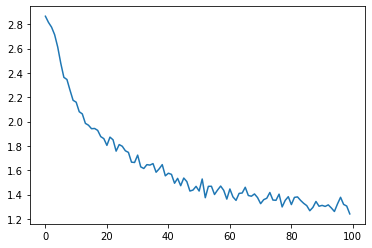

In [120]:
import matplotlib.ticker as ticker
plt.figure()
plt.plot(all_losses)

<ipython-input-121-a5b341ffc3a3>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-121-a5b341ffc3a3>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


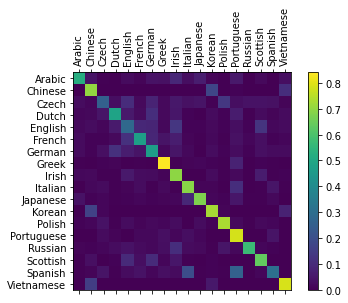

In [121]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()


In [122]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.71) Russian
(-1.10) Czech
(-2.49) English

> Jackson
(-0.19) Scottish
(-2.24) English
(-3.61) Dutch

> Satoshi
(-1.47) Japanese
(-1.52) Portuguese
(-1.57) Italian


## (b) GRU

In [123]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.quantized.dynamic.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        out = self.softmax(out)
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()
        return hidden

In [124]:
gru = GRUNet(n_letters, n_hidden, n_categories, n_layers=1)

C:\Users\amanl\anaconda3\lib\site-packages\torch\nn\quantized\dynamic\modules\rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [126]:
learning_rate = 0.005 
def train_GRU(category_tensor, line_tensor, hidden_size):
    hidden = gru.init_hidden(1)

    gru.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = gru(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in gru.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [127]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_GRU(category_tensor, line_tensor.unsqueeze(1), n_hidden)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 17s) 3.4770 Kwak / Irish ✗ (Korean)
10000 10% (0m 37s) 2.6731 Koole / Vietnamese ✗ (Dutch)
15000 15% (0m 58s) 2.7949 Abboud / Spanish ✗ (Arabic)
20000 20% (1m 21s) 0.6426 Pho / Vietnamese ✓
25000 25% (1m 42s) 3.7300 Sexton / Korean ✗ (English)
30000 30% (2m 7s) 2.8781 Beringer / Portuguese ✗ (French)
35000 35% (2m 27s) 2.6782 Cino / Chinese ✗ (Italian)
40000 40% (2m 46s) 2.8306 Frolandin / Polish ✗ (Russian)
45000 45% (3m 9s) 1.5850 Bassani / Arabic ✗ (Italian)
50000 50% (3m 29s) 2.9769 Pae / French ✗ (Korean)
55000 55% (3m 50s) 0.8576 Donovan / Irish ✓
60000 60% (4m 11s) 3.7973 Giles / Arabic ✗ (French)
65000 65% (4m 33s) 3.6201 Nozaki / Scottish ✗ (Japanese)
70000 70% (4m 53s) 1.3217 Sonoda / Spanish ✗ (Japanese)
75000 75% (5m 11s) 2.4333 Kerr / French ✗ (Scottish)
80000 80% (5m 30s) 2.0871 Malouf / Dutch ✗ (Arabic)
85000 85% (5m 48s) 2.4245 Descoteaux / Portuguese ✗ (French)
90000 90% (6m 10s) 1.9684 Mcghee / Dutch ✗ (English)
95000 95% (6m 31s) 0.6212 Yu / Korean ✓
1000

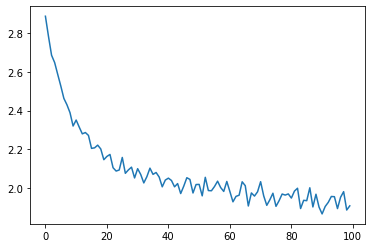

In [128]:
plt.figure()
plt.plot(all_losses)

<ipython-input-129-30bb701bc57b>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-129-30bb701bc57b>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


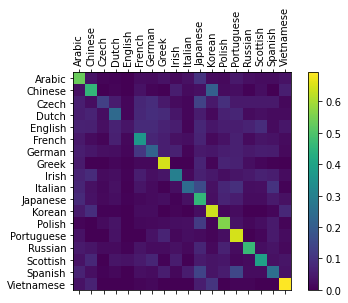

In [129]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate_GRU(line_tensor):
    hidden = gru.init_hidden(1)

    for i in range(line_tensor.size()[0]):
        output, hidden = gru(line_tensor[i].unsqueeze(1), hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate_GRU(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

## (c) LSTM

In [130]:
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x, h):
        out, h = self.lstm(x, h)
        out = self.fc(self.relu(out[:,-1]))
        out = self.softmax(out)
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        return hidden

In [131]:
lstm = LSTMNet(n_letters, n_hidden, n_categories, n_layers=1)

C:\Users\amanl\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [132]:
learning_rate = 0.005 

def train_LSTM(category_tensor, line_tensor,hidden_size,):
    hidden = lstm.init_hidden(1)

    lstm.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = lstm(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in lstm.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [133]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_LSTM(category_tensor, line_tensor.unsqueeze(1), n_hidden)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 26s) 2.9002 O'Mahoney / Portuguese ✗ (Irish)
10000 10% (0m 56s) 2.9550 Leclair / Japanese ✗ (French)
15000 15% (1m 23s) 2.8499 Nao / Czech ✗ (Chinese)
20000 20% (1m 49s) 2.8290 Capello / Japanese ✗ (Italian)
25000 25% (2m 16s) 2.8034 Pander / German ✗ (Dutch)
30000 30% (2m 43s) 2.8747 Pinho / Vietnamese ✗ (Portuguese)
35000 35% (3m 10s) 3.1122 Serafim / French ✗ (Portuguese)
40000 40% (3m 37s) 1.7856 Ziemniak / Polish ✓
45000 45% (4m 5s) 1.0360 Kasai / Japanese ✓
50000 50% (4m 35s) 1.3390 Rim / Korean ✓
55000 55% (5m 2s) 2.1902 Michel / Scottish ✗ (French)
60000 60% (5m 29s) 3.7535 Bolivar / English ✗ (Spanish)
65000 65% (5m 56s) 3.0691 Koeman / Irish ✗ (Dutch)
70000 70% (6m 22s) 1.3262 Pho / Korean ✗ (Vietnamese)
75000 75% (6m 49s) 3.1228 Dohman / Irish ✗ (German)
80000 80% (7m 17s) 1.6504 Ra / Vietnamese ✗ (Korean)
85000 85% (7m 44s) 2.0284 Hart / German ✗ (English)
90000 90% (8m 11s) 3.0325 Portoghese / Greek ✗ (Italian)
95000 95% (8m 43s) 1.4394 Docherty / Scottish ✓
10

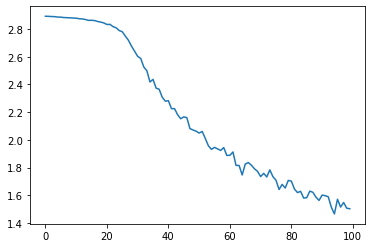

In [134]:
plt.figure()
plt.plot(all_losses)

<ipython-input-135-fd894f321631>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-135-fd894f321631>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


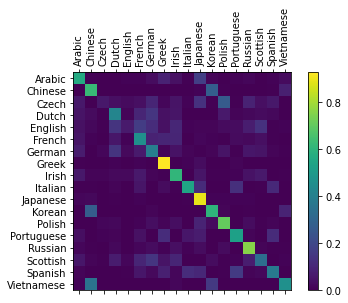

In [135]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate_LSTM(line_tensor):
    hidden = lstm.init_hidden(1)

    for i in range(line_tensor.size()[0]):
        output, hidden = lstm(line_tensor[i].unsqueeze(1), hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate_LSTM(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()